# Assignment 3
write your names here

In [1]:
import numpy as np
import torch

In [2]:
def linear_pca(X, k):
    mu=np.mean(X,axis=1)
    X_c=X-np.expand_dims(mu,axis=1)
    [U,Sigma,VT]=np.linalg.svd(X_c,full_matrices=False)
    S=np.expand_dims(Sigma[:k],axis=1)*VT[:k,:]
    return S

## Task 1.1

In [3]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

#im = np.array(imageio.imread('./mnist/d1/d1_0001.png'))

def read_data(exclude_digits=[], m=50):
    """
    reads mnist dataset
    param: 
        exclude_digits - list: list of digits to exclude from the returned dataset
        m - int: only return every m-th image sample
    return:
        X, y
        X - feature-matrix of flattened images (samplesize, features)
        y - labels for each row of X (samplesize,)
    """
    
    data_array = []
    labels_array = []
    
    for digit_directory in os.listdir('mnist'):
        if int(digit_directory[1]) not in exclude_digits:
            
            print('processing', digit_directory)
            for image_name in os.listdir(f'mnist/{digit_directory}'):
                
                if int(image_name[4:7]) % m == 0:
                    image_path = f'mnist/{digit_directory}/{image_name}'
                    label = int(digit_directory[1])
                    data_array.append(np.array(imageio.imread(image_path)).flatten())
                    labels_array.append(label)

    data = np.array(data_array)
    labels = np.array(labels_array)

    return data.astype(np.float32), labels
        

In [4]:
# read every 10th picture
# read every 50th picture
data, labels = read_data(m=7)
data = data.T
data.shape

processing d0
processing d1
processing d2
processing d3
processing d4
processing d5
processing d6
processing d7
processing d8
processing d9


(784, 8574)

In [5]:
S = linear_pca(data, 2)
S.shape

(2, 8574)

Text(0, 0.5, '2nd PCA score')

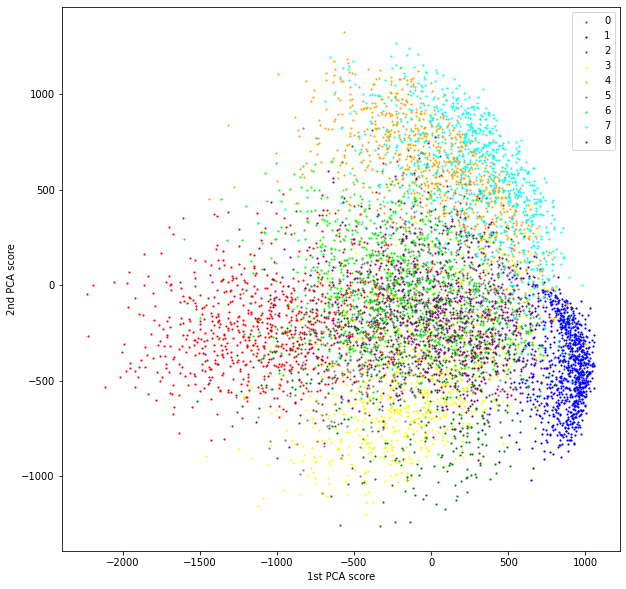

In [6]:
color_coding = {0: 'red',
                1: 'blue',
                2: 'green',
                3: 'yellow',
                4: 'orange',
                5: 'gray',
                6: 'lime',
                7: 'cyan',
                8: 'purple',
                9: 'pink'}
plt.figure(figsize=(10,10))
for i in range(9):
    mask = labels == i
    plt.scatter(S[0,mask], S[1,mask], marker='.', c=color_coding[i], s=8)

plt.legend(color_coding)
plt.xlabel('1st PCA score')
plt.ylabel('2nd PCA score')

## Task 1.2

In [7]:
def gram_pca(K,k):
    """
    implementation of Kernel-PCA
    params:
        K - np.array (samplesize, samplesize): Gram matrix
        k - int: number of principal components
    return:
        S - np.array (k, samplesize) loadings matrix for k 
    """
    n = K.shape[0]
    H = torch.eye(n) - 1/n * (torch.ones((n,1)) @ torch.ones((1,n)))
    H = H.float().cuda()
    K_centered = H @ K @ H
    Eig, V = torch.linalg.eig(K_centered)
    
    sigma_k_array = torch.sqrt(Eig[:k])
    sigma_k = torch.diag(sigma_k_array)
    V_k = V[:, :k]
    
    S = sigma_k @ V_k.T
    
    return S

## Task 1.3

In [8]:
X = torch.from_numpy(data).float().cuda()
K = X.T @ X


In [9]:
S_gram = gram_pca(K, 2)
print(S_gram.shape)
print(S_gram.is_cuda)


torch.Size([2, 8574])
True


c:\python\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, '2nd PCA score')

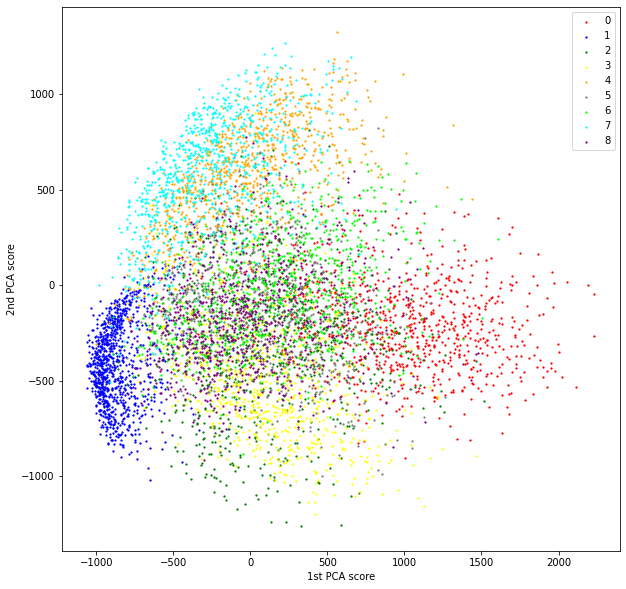

In [10]:
color_coding = {0: 'red',
                1: 'blue',
                2: 'green',
                3: 'yellow',
                4: 'orange',
                5: 'gray',
                6: 'lime',
                7: 'cyan',
                8: 'purple',
                9: 'pink'}

plt.figure(figsize=(10,10))
for i in range(9):
    mask = labels == i
    plt.scatter(S_gram[0,mask].cpu(), S_gram[1,mask].cpu(), marker='.', c=color_coding[i], s=8)

plt.legend(color_coding)
plt.xlabel('1st PCA score')
plt.ylabel('2nd PCA score')

## Task 1.4

In [11]:
def compute_gaussian_gram_matrix(X, sigma):
    """
    computes the gaussian gram matrix given the feature matrix and the variance sigma.
    params:
        X - feature matrix (features, samplesize)
        sigma - float
    returns:
        K - gram matrix (samplesize, samplesize)
    """
    # first compute ||x-y|| and place the results on corresponding diagonals
    # main diagonal is only zeros w.r.t the argument
    n = X.shape[1]
    argument = torch.zeros((n,n)).cuda()
    
    # side diagonals:
    for i in range(1,n):
        x_minus_y = X[:,i:] - X[:,:-i]
        squared_norm = torch.linalg.norm(x_minus_y, axis=0)**2
        upper_diag = torch.diag(squared_norm, i).cuda()
        lower_diag = torch.diag(squared_norm, -i).cuda()
        argument = argument + upper_diag + lower_diag
        if i % 100 == 0:
            print('\rcalculated diagonals: ', i, end=''*10)
        
    # scale exponential argument according to variance
    argument = -1/(2*sigma**2) * argument
    
    # calculate exponential
    K = torch.exp(argument)
    
    return K

def gaussian_kernel_pca(X, k, sigma):
    K=compute_gaussian_gram_matrix(X,sigma)
    S=gram_pca(K,k)
    return S

## Task 1.5

In [12]:
S_gauss = gaussian_kernel_pca(X, 2, 1000)

calculated diagonals:  8500

Text(0, 0.5, '2nd PCA score')

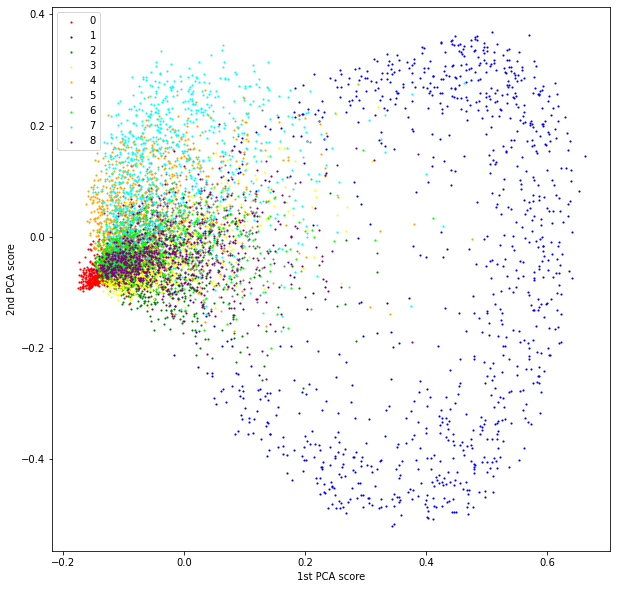

In [13]:
color_coding = {0: 'red',
                1: 'blue',
                2: 'green',
                3: 'yellow',
                4: 'orange',
                5: 'gray',
                6: 'lime',
                7: 'cyan',
                8: 'purple',
                9: 'pink'}

plt.figure(figsize=(10,10))
for i in range(9):
    mask = labels == i
    plt.scatter(S_gauss[0,mask].cpu(), S_gauss[1,mask].cpu(), marker='.', c=color_coding[i], s=5)

plt.legend(color_coding)
plt.xlabel('1st PCA score')
plt.ylabel('2nd PCA score')